# **Forecasting Bitcoin Prices via ARIMA,  PROPHET, and LSTM**




### **Introduction**

The cryptocurrency Bitcoin continues to make world headlines and rise in popularity as more and more people/organizations begin adopting it. In this notebook, I will test the Bitcoin forecasting abilities of 4 different Machine Learning models in Python: ARIMA, Prophet, XGBoost, and LSTM. By splitting the data into a testing and training set, I will compare each model’s performance with one another and conclude which performed best. 

Let me know your thoughts, comments, or suggestions below! I'd appreciate it!

### **Table of Contents**

This notebook will be broken down into 6 sections:
1. EDA
2. PROPHET
3. SARIMA
4. LSTM
5. CONCLUSION (Comparing each model's RMSE)

**Standarized Procedure for Testing Models**
- Each model will be trained on the first 75% of the data and tested on the last 25%. The bitcoin data will be resampled to days and restricted to the past 4 years only (from March 31st, 2021).
- The Root Mean Square Error (RMSE) of each model will determine which is the best. The RMSE is the standard deviation of the residuals - or more simply how spread out the residuals are.


## **1. Exploratory Data Analysis**


In [11]:
# import libraries
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.plotting import autocorrelation_plot

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [12]:
# read the dataset into a dataframe
df = pd.read_csv('bitcoin.csv')
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Here I start cleaning the data. Firstly, converting Timestamp to datetime64
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')
# sets the index as the date
df.index = df.Timestamp
# Resamples the data to the average daily value of each column. Removes excessive frequency
df = df.resample('D').mean()
# drops any missing values that are present
df = df.dropna()
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603
2012-01-01,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667
2012-01-02,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000
2012-01-03,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500
2012-01-04,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159


In [14]:
print(df.shape)
# Now we have 3,376 rows instead of 4 million - with no missing values and accurate datetime information

(3376, 7)


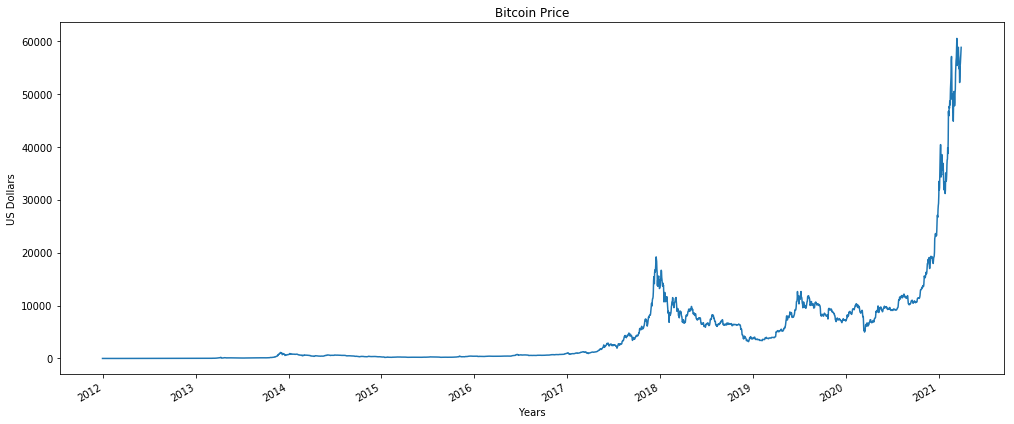

In [15]:
# graph bitcoin price over the years
df.Weighted_Price.plot(title = "Bitcoin Price", figsize=(14,6))
plt.tight_layout()
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.show()
# As the graph shows 2017-2021 price behavior looks signficantly different than 2012-2017

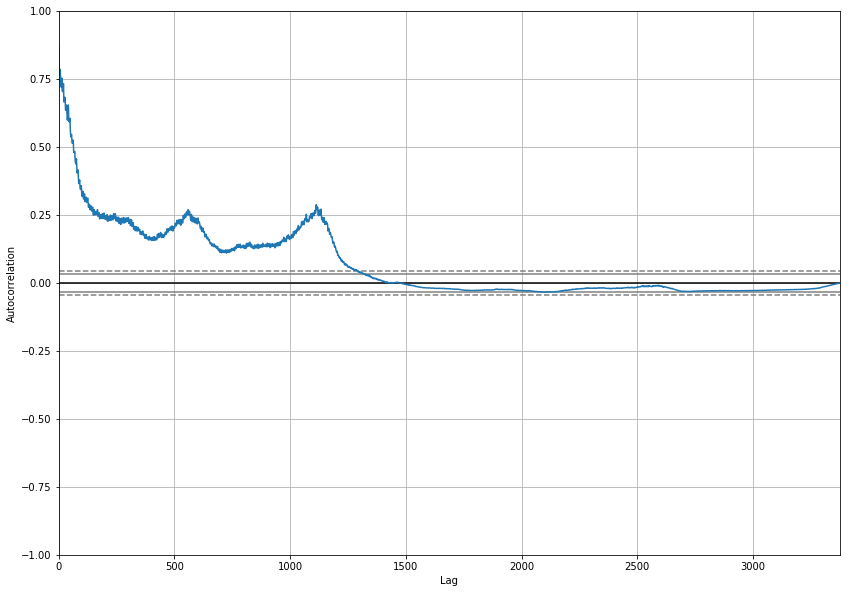

In [126]:
# Plot the autocorrelation to see if there are a large number of lags in the time series.
autocorrelation_plot(df)
plt.show()

In [127]:
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders


In [185]:
Weekly_price=df.resample('W').mean()

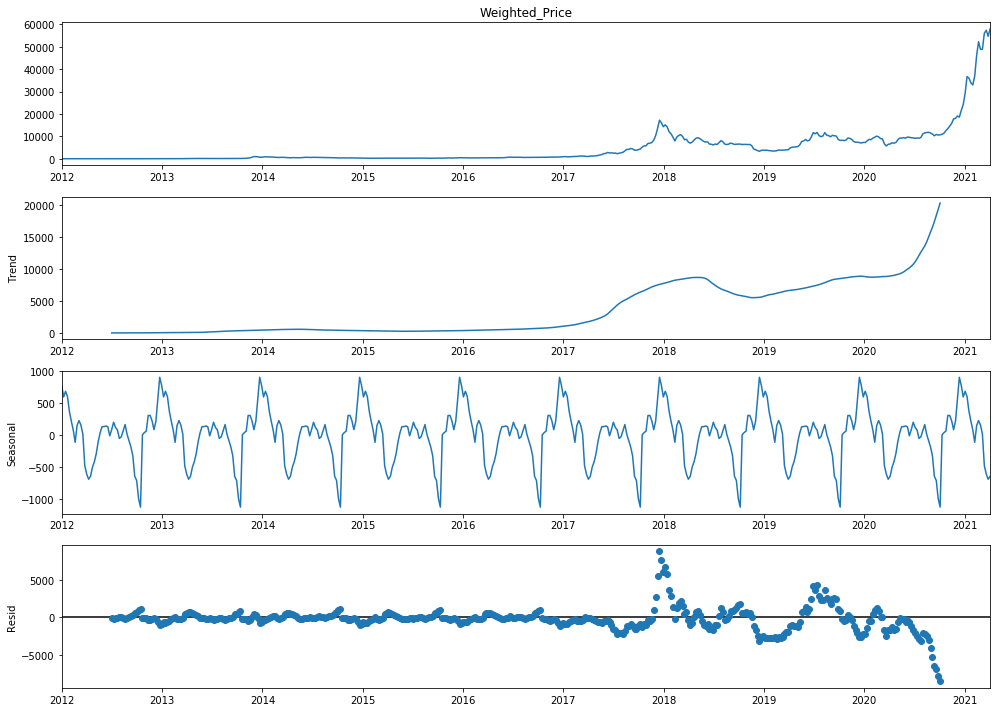

In [129]:
plt.rc("figure", figsize=(14,10))
decompose=seasonal_decompose(Weekly_price.Weighted_Price)
decompose.plot();

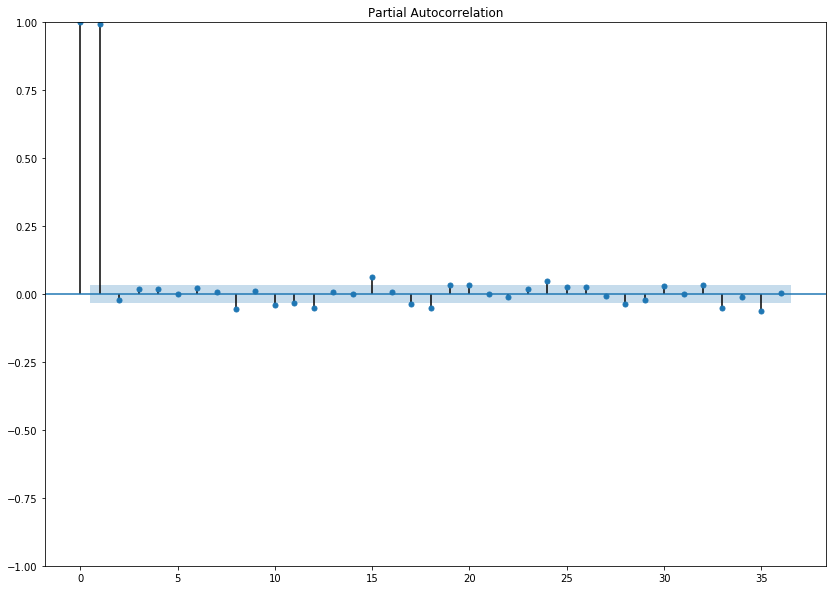

In [130]:
plot_pacf(df.Weighted_Price);

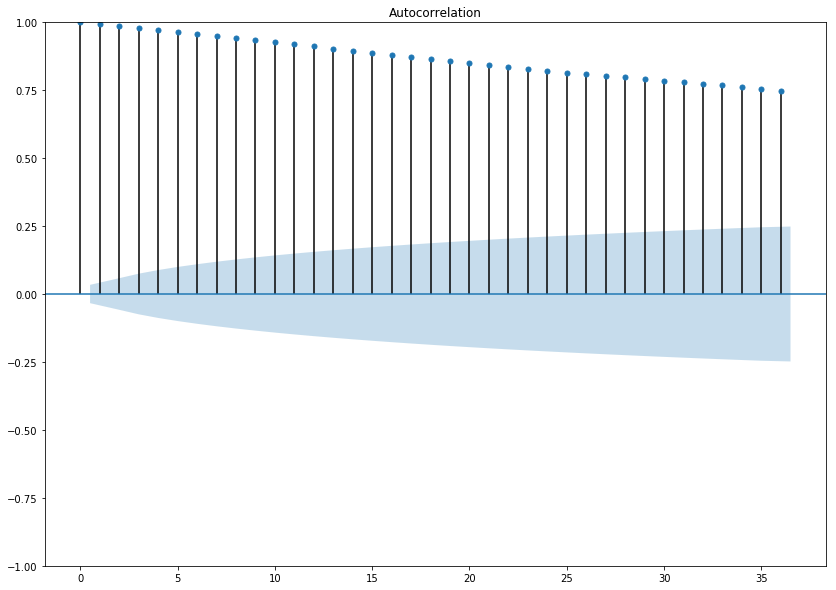

In [131]:
plot_acf(df.Weighted_Price);

In [132]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [133]:
adf_test(df.Weighted_Price)

Augmented Dickey-Fuller Test: 
ADF test statistic         6.185633
p-value                    1.000000
# lags used               29.000000
# observations          3346.000000
critical value (1%)       -3.432306
critical value (5%)       -2.862404
critical value (10%)      -2.567230
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [134]:
diff_price=df.Weighted_Price.diff().dropna()
adf_test(diff_price)

Augmented Dickey-Fuller Test: 
ADF test statistic     -9.086538e+00
p-value                 3.926412e-15
# lags used             2.800000e+01
# observations          3.346000e+03
critical value (1%)    -3.432306e+00
critical value (5%)    -2.862404e+00
critical value (10%)   -2.567230e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [135]:
adf_test(Weekly_price.Weighted_Price)

Augmented Dickey-Fuller Test: 
ADF test statistic        2.523056
p-value                   0.999057
# lags used              10.000000
# observations          473.000000
critical value (1%)      -3.444251
critical value (5%)      -2.867670
critical value (10%)     -2.570035
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [136]:
Weekly_price_diff=Weekly_price.diff().dropna()
adf_test(Weekly_price_diff.Weighted_Price)

Augmented Dickey-Fuller Test: 
ADF test statistic       -1.145787
p-value                   0.696472
# lags used              11.000000
# observations          471.000000
critical value (1%)      -3.444310
critical value (5%)      -2.867696
critical value (10%)     -2.570049
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [141]:
from pmdarima import auto_arima

model=auto_arima(Weekly_price.Weighted_Price, maxiter=200, seasonal=True, m=12,max_p=8, max_q=8, n_jobs=-1 )
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  484
Model:             SARIMAX(2, 2, 1)x(1, 0, 1, 12)   Log Likelihood               -3893.016
Date:                            Tue, 07 Dec 2021   AIC                           7798.033
Time:                                    23:05:47   BIC                           7823.101
Sample:                                         0   HQIC                          7807.885
                                            - 484                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3251      0.019     17.511      0.000       0.289       0.362
ar.L2         -0.4813      0.016    -29.325      0.000      -0.514      -0.449
ma.L1         -0.8608      0.012    -74.616      0.000      -0.883      -0.838
ar.S.L12      -0.7737      0.091     -8.544      0.000      -0.951      -0.596
ma.S.L12       0.8791      0.072     12.225      0.000       0.738       1.020
sigma2      6.036e+05   1.42e+04     42.385      0.000    5.76e+05    6.32e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):              4951.10
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):             685.19   Skew:                             0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

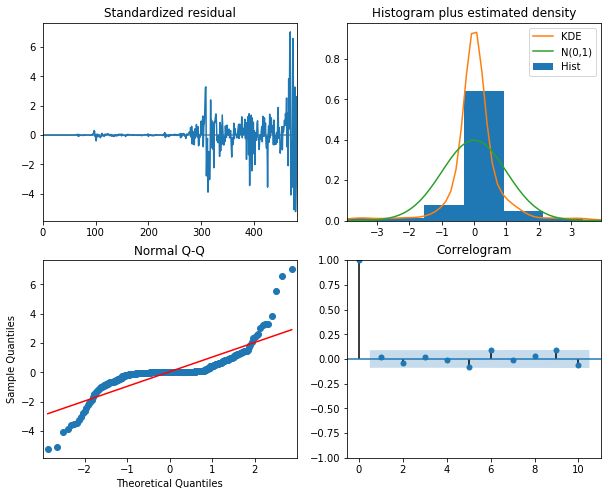

In [142]:
model.plot_diagnostics(figsize=(10,8))
plt.show()

In [143]:
print(len(Weekly_price.Weighted_Price))
# Next the data is split as usual
X = Weekly_price.Weighted_Price
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]

train.shape, test.shape

484


((363,), (121,))

In [195]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train,order=(2,1,4),seasonal_order=(1,0,1,12))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                       Weighted_Price   No. Observations:                  363
Model:             SARIMAX(2, 1, 4)x(1, 0, [1], 12)   Log Likelihood               -2650.136
Date:                              Tue, 07 Dec 2021   AIC                           5318.273
Time:                                      23:12:52   BIC                           5353.297
Sample:                                  01-01-2012   HQIC                          5332.196
                                       - 12-09-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0177      0.030    -33.819      0.000      -1.077      -0.959
ar.L2         -0.9139      0.032    -28.497      0.000      -0.977      -0.851
ma.L1          1.6160      0.042     38.737      0.000       1.534       1.698
ma.L2          1.5645      0.054     28.816      0.000       1.458       1.671
ma.L3          0.6847      0.037     18.508      0.000       0.612       0.757
ma.L4          0.1509      0.025      6.044      0.000       0.102       0.200
ar.S.L12       0.2892      0.160      1.812      0.070      -0.024       0.602
ma.S.L12      -0.5271      0.148     -3.569      0.000      -0.817      -0.238
sigma2      1.511e+05   4913.125     30.763      0.000    1.42e+05    1.61e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              4106.36
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):             166.82   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [196]:
start=len(train)
end=start+len(test)-1
print(start, end)
prediction=model.predict(start, end, dynamic=True )

363 483


In [197]:
print('mean_squared_error', mean_squared_error(prediction, test))
rmse = sqrt(mean_squared_error(test, prediction))
rmse

mean_squared_error 230077607.65936834


15168.309321060417

mean_squared_error 230077607.65936834


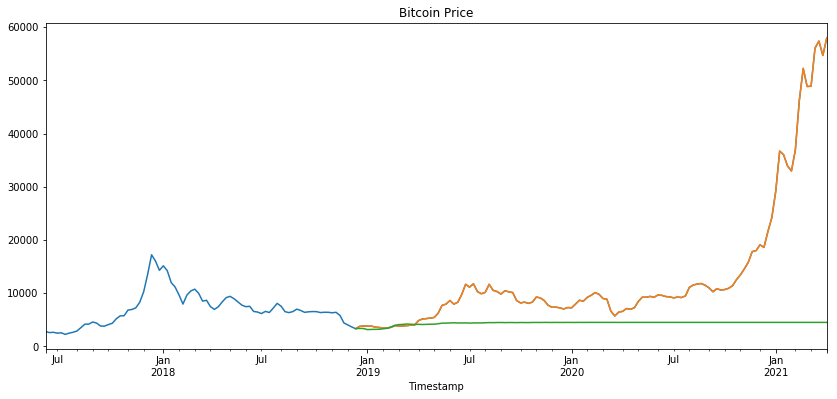

In [199]:
print('mean_squared_error', mean_squared_error(prediction, test))

plt.figure(figsize=(14,7))
Weekly_price.Weighted_Price.iloc[-200:].plot(title = "Bitcoin Price", figsize=(14,6))
test.plot()
prediction.plot()

In [16]:
DF=df.resample('M').mean()
print(len(DF))
# Next the data is split as usual
X = DF
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]

train.shape, test.shape

112


((84, 7), (28, 7))

In [19]:
from statsmodels.tsa.arima.model import ARIMA

from itertools import product

r=range(6)
a= list(product(r,r))


mn=rsme=10**5
aic=10**5
best_param=[]
best_param_aic=[]

for i in a:
    model=ARIMA(train.Weighted_Price, order=(i[0],3,i[1]))
    model=model.fit()
    start=len(train.Weighted_Price)
    end=len(train.Weighted_Price)+len(test.Weighted_Price)-1

    predicted=model.predict(start=start, end=end, type='levels')
    rsme=sqrt(mean_squared_error(predicted,test.Weighted_Price))
    
    if mn> rsme:
        best_param.clear()
        mn=rsme
        best_param.append([i[0],3,i[1]])
    if aic > model.aic:
        aic=model.aic
        best_param_aic.clear()
        best_param_aic.append([i[0],3,i[1]])
        
print(best_param, mn , aic, best_param_aic)

/Users/imanjani/.local/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/imanjani/.local/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/imanjani/.local/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/imanjani/.local/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/imanjani/.local/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/imanjani/.local/lib/pyt

[[3, 3, 5]] 11371.931341928368 1366.6695258891762 [[0, 3, 3]]


/Users/imanjani/.local/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


11371.931341928368 AIC 1376.2895472180358


/Users/imanjani/.local/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


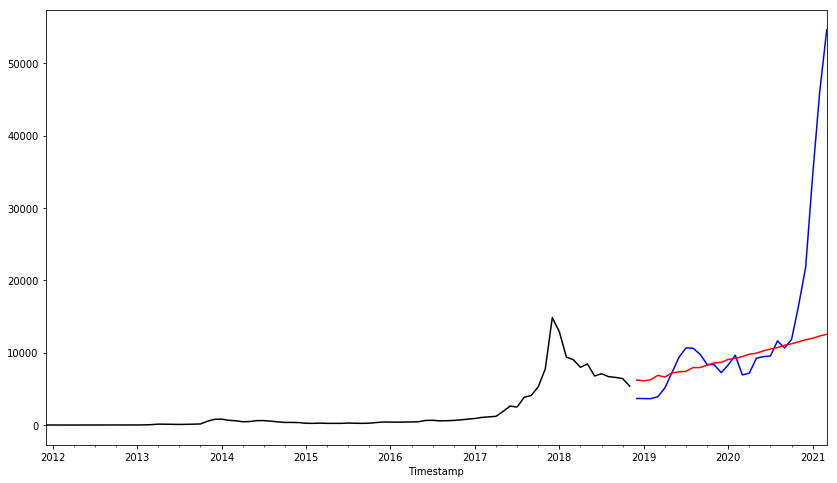

In [23]:
model=ARIMA(train.Weighted_Price, order=(3,3,5))
model=model.fit()

start=len(train)
end=len(train)+len(test)-1

predicted=model.predict(start=start, end=end, type='levels', dynamic=True)
    
rsme=sqrt(mean_squared_error(predicted,test.Weighted_Price))

plt.figure(figsize=(14,8))
print(rsme, 'AIC', model.aic)
train.Weighted_Price.plot(color='black')
test.Weighted_Price.plot(color='blue')
predicted.plot(color='red')

## **1A. ROLLING FORECAST ARIMA**
I first created a rolling forecast ARIMA model in order to get a baseline for what a great RMSE is. However, since this model predicts in rolling day by day increments, it isn’t fair to compare to the other models. As plotted below, the predictions are in red and the actual prices are in blue. However, we have to zoom in more to distinguish the two.


In [203]:
from statsmodels.tsa.arima.model import ARIMA
# We're going to create a dataframe for just the price (the index is still the date)
price = df.Weighted_Price
# Next we're going to assign 70% percent of the data to training and 30% for testing
X = price.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

predicted=6302.231244, expected=6135.543847
predicted=6069.689988, expected=6023.889667
predicted=6023.792660, expected=6202.876879
predicted=6230.828498, expected=6201.552619
predicted=6212.999296, expected=6095.577403
predicted=6061.321275, expected=6081.380557
predicted=6083.884263, expected=5903.335065
predicted=5874.603975, expected=6363.429736
predicted=6437.667539, expected=6349.980905
predicted=6380.595571, expected=6452.834154
predicted=6430.095994, expected=6596.638644
predicted=6650.088497, expected=6570.766853
predicted=6558.169786, expected=6581.029785
predicted=6575.893375, expected=6541.718841
predicted=6541.391754, expected=6573.830823
predicted=6574.450688, expected=6738.872118
predicted=6774.205019, expected=6705.525899
predicted=6702.295389, expected=6480.199576
predicted=6427.218038, expected=6354.062268
predicted=6330.231572, expected=6218.799425
predicted=6201.382213, expected=6236.444559
predicted=6234.309898, expected=6235.684071
predicted=6243.649017, expected=

predicted=3760.526335, expected=3717.518933
predicted=3734.875585, expected=3701.742855
predicted=3681.926141, expected=3873.097678
predicted=3909.308334, expected=3787.887224
predicted=3778.018889, expected=3756.609194
predicted=3735.498136, expected=3700.678699
predicted=3700.897595, expected=3824.381088
predicted=3843.657193, expected=3829.104391
predicted=3837.835341, expected=3784.333248
predicted=3766.042670, expected=3834.134900
predicted=3845.922765, expected=3885.331236
predicted=3899.885820, expected=4022.403776
predicted=4045.154446, expected=4006.822508
predicted=4008.294945, expected=4010.343312
predicted=4003.228001, expected=3792.036097
predicted=3757.638074, expected=3636.680782
predicted=3597.450805, expected=3626.334444
predicted=3632.348457, expected=3575.310055
predicted=3567.412043, expected=3582.604522
predicted=3576.993193, expected=3640.293337
predicted=3654.557121, expected=3603.489606
predicted=3596.713409, expected=3603.110896
predicted=3598.041756, expected=

predicted=11462.284288, expected=10688.316670
predicted=10512.275452, expected=10303.947255
predicted=10232.867338, expected=11345.214705
predicted=11559.252707, expected=11759.042505
predicted=11829.881665, expected=11139.493770
predicted=10956.617828, expected=11415.369265
predicted=11513.306697, expected=11311.476748
predicted=11334.239587, expected=11794.103580
predicted=11826.440653, expected=12513.873100
predicted=12677.394928, expected=12648.777230
predicted=12653.571736, expected=11583.331144
predicted=11376.040949, expected=11584.532267
predicted=11612.505359, expected=11428.597804
predicted=11454.494994, expected=10857.026634
predicted=10687.591932, expected=10417.313950
predicted=10354.272863, expected=10355.675153
predicted=10356.946025, expected=9577.424254
predicted=9415.228457, expected=10054.174637
predicted=10119.903771, expected=10472.448829
predicted=10587.740557, expected=10680.276549
predicted=10659.198835, expected=10577.614454
predicted=10583.245067, expected=104

predicted=7183.984492, expected=7195.811553
predicted=7196.354013, expected=7072.477634
predicted=7048.169780, expected=7218.040867
predicted=7243.228107, expected=7321.919471
predicted=7349.803202, expected=7430.027210
predicted=7439.606496, expected=7533.920319
predicted=7561.300004, expected=7929.897114
predicted=8005.157217, expected=8235.623274
predicted=8295.065375, expected=7898.569229
predicted=7818.624261, expected=7888.135215
predicted=7891.838559, expected=8113.360826
predicted=8174.631658, expected=8111.715363
predicted=8085.100203, expected=8102.893845
predicted=8102.180367, expected=8574.611704
predicted=8679.729784, expected=8743.692144
predicted=8769.433644, expected=8674.415975
predicted=8643.048326, expected=8852.804577
predicted=8906.802992, expected=8891.817032
predicted=8895.485875, expected=8847.166822
predicted=8823.218009, expected=8644.708000
predicted=8614.815768, expected=8646.193567
predicted=8644.880172, expected=8665.685486
predicted=8673.085588, expected=

predicted=9093.862981, expected=9062.059217
predicted=9055.225650, expected=9216.144577
predicted=9246.148113, expected=9269.029050
predicted=9280.026793, expected=9346.710768
predicted=9357.608649, expected=9327.675122
predicted=9328.918053, expected=9200.495958
predicted=9171.098169, expected=9238.790536
predicted=9251.095669, expected=9249.438247
predicted=9250.874277, expected=9278.539034
predicted=9278.596999, expected=9220.123138
predicted=9212.253633, expected=9221.474235
predicted=9221.526290, expected=9130.464283
predicted=9113.760921, expected=9134.885430
predicted=9133.878462, expected=9162.235905
predicted=9171.293094, expected=9154.807428
predicted=9148.769983, expected=9177.715587
predicted=9184.539559, expected=9309.146587
predicted=9337.301741, expected=9366.081212
predicted=9374.387625, expected=9541.144947
predicted=9575.090943, expected=9557.228596
predicted=9561.855668, expected=9619.470009
predicted=9627.611328, expected=9834.343451
predicted=9883.862933, expected=

predicted=28990.851318, expected=29288.824917
predicted=29347.863609, expected=30757.429533
predicted=31201.677697, expected=33467.362526
predicted=34200.986193, expected=31856.122685
predicted=31395.346219, expected=32273.087909
predicted=32542.989399, expected=34904.997383
predicted=35558.004369, expected=38067.445472
predicted=38521.289795, expected=39807.603739
predicted=40321.325319, expected=40395.370088
predicted=40890.356511, expected=39727.277526
predicted=39831.187326, expected=34277.110008
predicted=32334.046469, expected=34840.250153
predicted=35223.059278, expected=34673.974752
predicted=34627.848188, expected=38508.456683
predicted=39137.326739, expected=37468.427964
predicted=37559.320418, expected=36843.154360
predicted=36143.474810, expected=35650.764186
predicted=35874.243172, expected=36046.172744
predicted=36066.690724, expected=36858.910679
predicted=37169.413475, expected=35152.737304
predicted=34627.055680, expected=32949.072452
predicted=32358.176956, expected=3

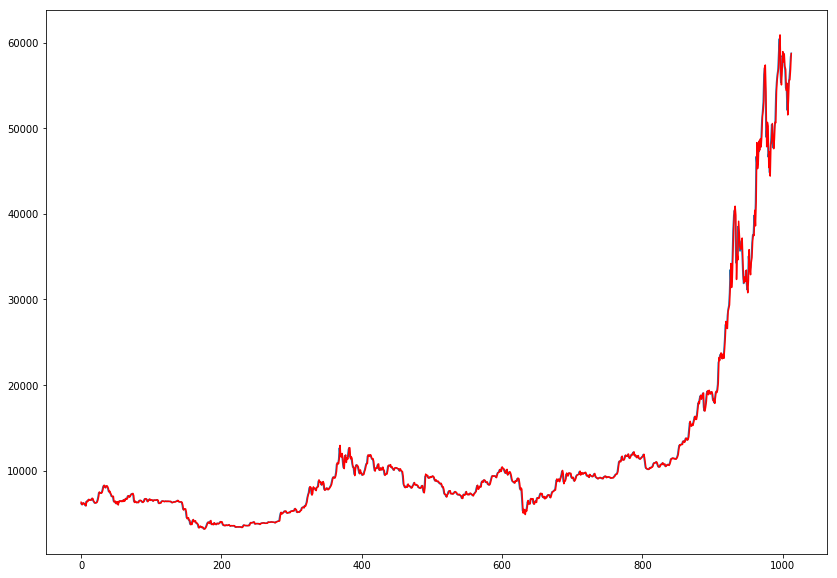

In [204]:
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

Test RMSE: 914.737


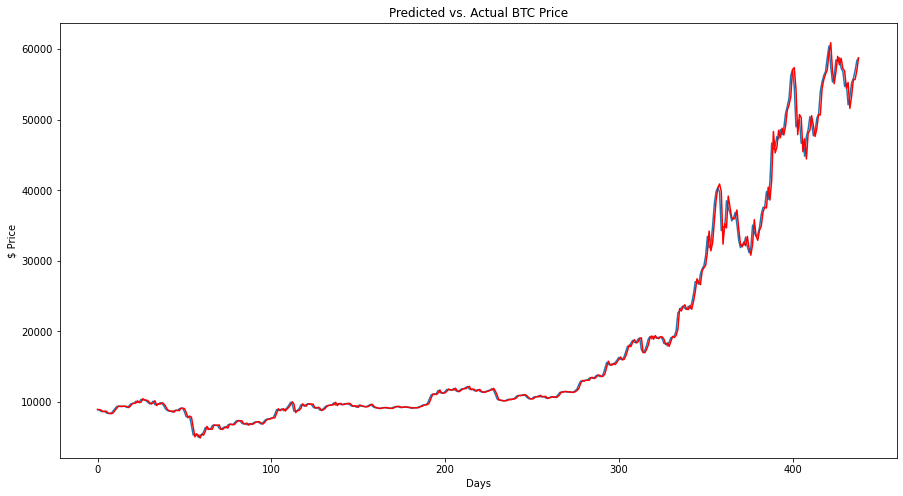

In [12]:
# if we look at this model, the predicted is indistinuishable from the actual price
# this is simply because it's predicting day by day.
plt.figure(figsize=(15,8))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.xlabel('Days')
plt.ylabel('$ Price')
plt.title('Predicted vs. Actual BTC Price')
plt.show()

Test RMSE: 914.737


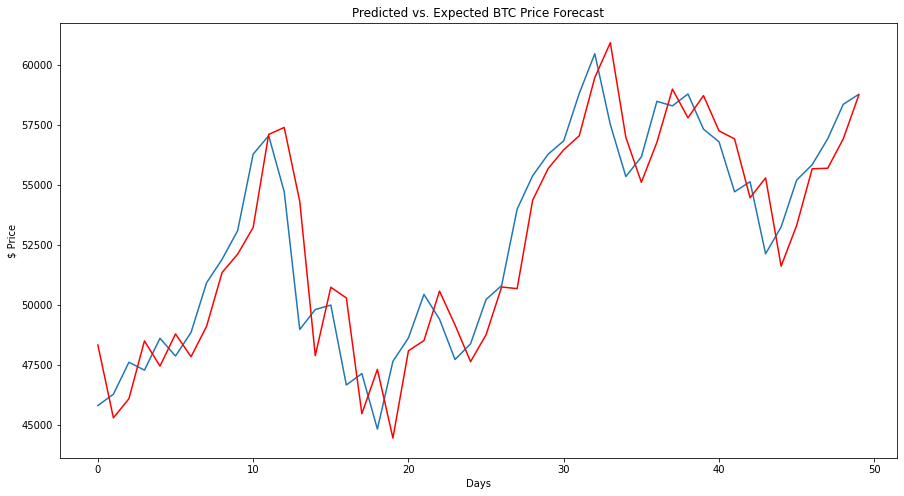

In [13]:
# I plot 50 days to more accurately see how the models works with its lag
plt.figure(figsize=(15,8))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test[-50:])
plt.plot(predictions[-50:], color='red')
plt.xlabel('Days')
plt.ylabel('$ Price')
plt.title('Predicted vs. Expected BTC Price Forecast')
plt.show()

## **2. PROPHET**
The Prophet library is an open-source library developed by Facebook and designed for automatic forecasting of time series data. This model mainly focuses on predicting trends and seasonality. However due to its easy use I decided to implement this model first with default settings. As plotted below the prophet model predicts the price of bitcoin will fall. In addition, the model provides upper and lower bounds estimates as well (edges of shaded region). While the upper bounds estimate has an accurate slope direction, this model didn’t perform well when compared to the test data.

In [26]:
# importing Prophet model
# importing prophet library
import fbprophet
from fbprophet import Prophet
# print version number
print('Prophet %s' % fbprophet.__version__)

Prophet 0.5


In [253]:
# For prophet we have to fit the dataframe to two columns: ds, y
df3 = df.copy()
df3.reset_index(inplace=True)
df3 = df3[['Timestamp', 'Weighted_Price']]
df3.columns = ['ds', 'y']
# Next the data is split as usual
X = df3
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]

In [254]:
model = Prophet()
# fit the model
model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [255]:
# frequency is a day and periods are length of test data
future = model.make_future_dataframe(periods=len(test), freq='D')
forecasting = model.predict(future)
# prediction is stored and RMSE is returned
y_true = test['y'].values
y_pred = forecasting.yhat.values[-len(test):]
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 11294.792


In [256]:
forecasting.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-12-31,-179.856791,-472.838449,3211.998901,-179.856791,-179.856791,1475.013257,1475.013257,1475.013257,-2.802117,-2.802117,-2.802117,1477.815375,1477.815375,1477.815375,0.0,0.0,0.0,1295.156466
1,2012-01-01,-179.118694,-494.769585,3063.069480,-179.118694,-179.118694,1437.719365,1437.719365,1437.719365,3.179791,3.179791,3.179791,1434.539574,1434.539574,1434.539574,0.0,0.0,0.0,1258.600671
2,2012-01-02,-178.380597,-478.042175,3129.130953,-178.380597,-178.380597,1398.824968,1398.824968,1398.824968,7.648528,7.648528,7.648528,1391.176440,1391.176440,1391.176440,0.0,0.0,0.0,1220.444371
3,2012-01-03,-177.642500,-479.889413,3034.298731,-177.642500,-177.642500,1356.471914,1356.471914,1356.471914,8.095077,8.095077,8.095077,1348.376837,1348.376837,1348.376837,0.0,0.0,0.0,1178.829414
4,2012-01-04,-176.904403,-660.892350,2871.378091,-176.904403,-176.904403,1308.269581,1308.269581,1308.269581,1.573684,1.573684,1.573684,1306.695897,1306.695897,1306.695897,0.0,0.0,0.0,1131.365178


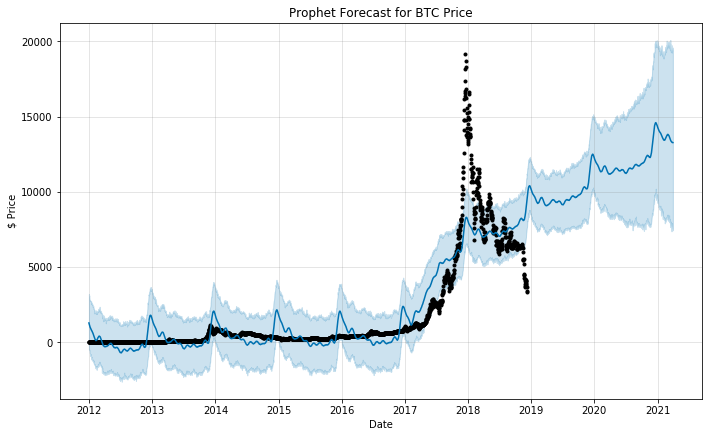

In [257]:
# Plotting forecast
model.plot(forecasting)
plt.title('Prophet Forecast for BTC Price')
plt.ylabel('$ Price')
plt.xlabel('Date')
plt.show()

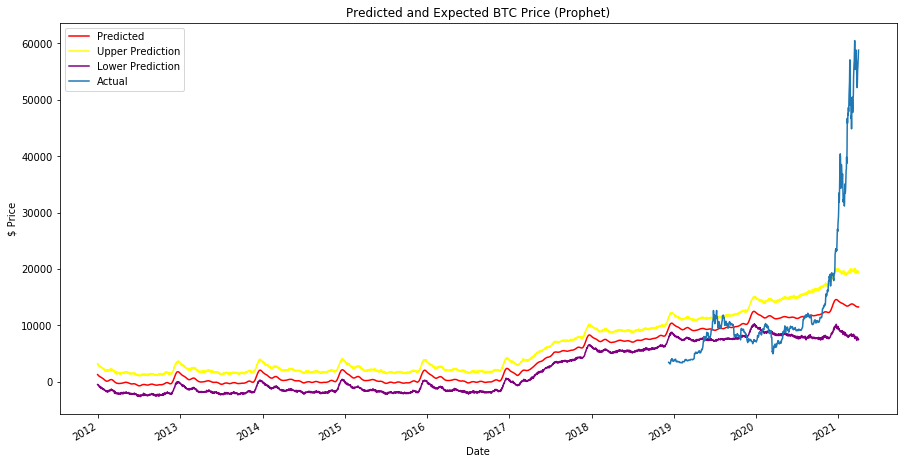

In [258]:
# Plotting forecast with test data
ax = forecasting.plot(x='ds', y='yhat', legend=True, label="Predicted", figsize=(15,8), color='red')
forecasting.plot(x='ds', y='yhat_upper', legend=True, label='Upper Prediction', ax=ax, color='yellow')
forecasting.plot(x='ds', y='yhat_lower', legend=True, label='Lower Prediction', ax=ax, color='purple')
test.plot(x='ds', y='y', legend=True, label='Actual', ax=ax)
plt.ylabel('$ Price')
plt.xlabel('Date')
plt.title('Predicted and Expected BTC Price (Prophet)')
plt.legend(loc='best')
plt.show()

In [ ]:
DF=df.resample('W').mean()

In [28]:
# For prophet we have to fit the dataframe to two columns: ds, y
df3 = DF.copy()
df3.reset_index(inplace=True)
df3 = df3[['Timestamp', 'Weighted_Price']]
df3.columns = ['ds', 'y']
# Next the data is split as usual
X = df3
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
train.shape, test.shape

((89, 2), (23, 2))

In [ ]:
model = Prophet()
# fit the model
model.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [ ]:
# frequency is a day and periods are length of test data
future = model.make_future_dataframe(periods=len(test), freq='M')
forecasting = model.predict(future)
# prediction is stored and RMSE is returned
y_true = test['y'].values
y_pred = forecasting.yhat.values[-len(test):]
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print('Test RMSE: %.3f' % rmse)


In [ ]:
# Plotting forecast
model.plot(forecasting)
plt.title('Prophet Forecast for BTC Price')
plt.ylabel('$ Price')
plt.xlabel('Date')
plt.show()

## **3. ARIMA MODEL**
Next is ARIMA, an acronym that stands for AutoRegressive Integrated Moving Average. ARIMA is a widely used statistical method for analyzing and forecasting time series data. It consists of a suite of standard structures in time series data and provides a simple yet powerful method for making skillful time series forecasts. ARIMA models have 3 parameters (p, d, q), which indicate the specific ARIMA model being used. I simply applied parameters that I’ve used on different time series data in the past, which could’ve possibly led to an unfavorable model.

In [21]:
from statsmodels.tsa.arima_model import ARIMA
# method to be used later
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i-interval]
        diff.append(value)
    return np.array(diff)

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [22]:
print(len(test))

439


In [23]:
# Split the data as usual 70, 30
price = df2.Weighted_Price
X = price.values
datesX = price.index
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
days_in_year = 365
plotDates = datesX[size:len(X)]

# Next we will forecast with ARIMA using 5,1,0
differenced = difference(train, days_in_year)
model = ARIMA(differenced, order=(5, 1, 0))
model_fit = model.fit()
start_index = len(differenced)
end_index = start_index + 438
forecast = model_fit.predict(start=start_index, end=end_index)

history = [x for x in train]
day = 1
predicted_results = list()

# store predicted results 
for yhat in forecast:
    inverted = inverse_difference(history, yhat, days_in_year)
    print("Predicted Day %d: %f" % (day, inverted))
    history.append(inverted)
    predicted_results.append(inverted)
    day += 1


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Predicted Day 1: 3678.996300
Predicted Day 2: 3690.584941
Predicted Day 3: 3595.145596
Predicted Day 4: 3545.495392
Predicted Day 5: 3552.934743
Predicted Day 6: 3568.268541
Predicted Day 7: 3552.775660
Predicted Day 8: 3556.261859
Predicted Day 9: 3570.947030
Predicted Day 10: 3543.905276
Predicted Day 11: 3436.117255
Predicted Day 12: 3397.177743
Predicted Day 13: 3423.271251
Predicted Day 14: 3423.546939
Predicted Day 15: 3415.844338
Predicted Day 16: 3431.356997
Predicted Day 17: 3424.078840
Predicted Day 18: 3413.194452
Predicted Day 19: 3418.573441
Predicted Day 20: 3370.533563
Predicted Day 21: 3365.433657
Predicted Day 22: 3455.058870
Predicted Day 23: 3614.106758
Predicted Day 24: 3607.111115
Predicted Day 25: 3594.390119
Predicted Day 26: 3577.129781
Predicted Day 27: 3581.229537
Predicted Day 28: 3568.077358
Predicted Day 29: 3569.700168
Predicted Day 30: 3586.930842
Predicted Day 31: 3584.543137
Predicted Day 32: 3755.929337
Predicted Day 33: 3899.987676
Predicted Day 34: 3

In [24]:
rmse = np.sqrt(mean_squared_error(test, predicted_results))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 19633.649


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  655
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -4862.648
Method:                       css-mle   S.D. of innovations            405.410
Date:                Fri, 30 Jul 2021   AIC                           9739.296
Time:                        22:41:16   BIC                           9770.688
Sample:                             1   HQIC                          9751.468
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7440     21.291     -0.035      0.972     -42.474      40.986
ar.L1.D.y      0.2159      0.039      5.529      0.000       0.139       0.292
ar.L2.D.y      0.0256      0.040      0.643      0.5

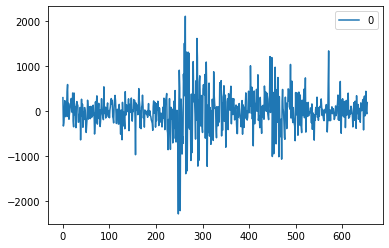

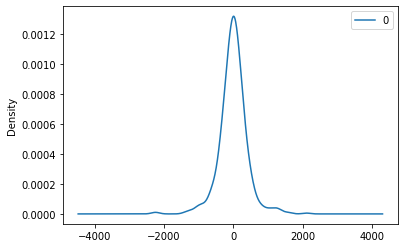

                 0
count   655.000000
mean     -0.088772
std     405.730521
min   -2280.438364
25%    -195.521870
50%       7.393693
75%     194.263830
max    2110.040288


In [25]:
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

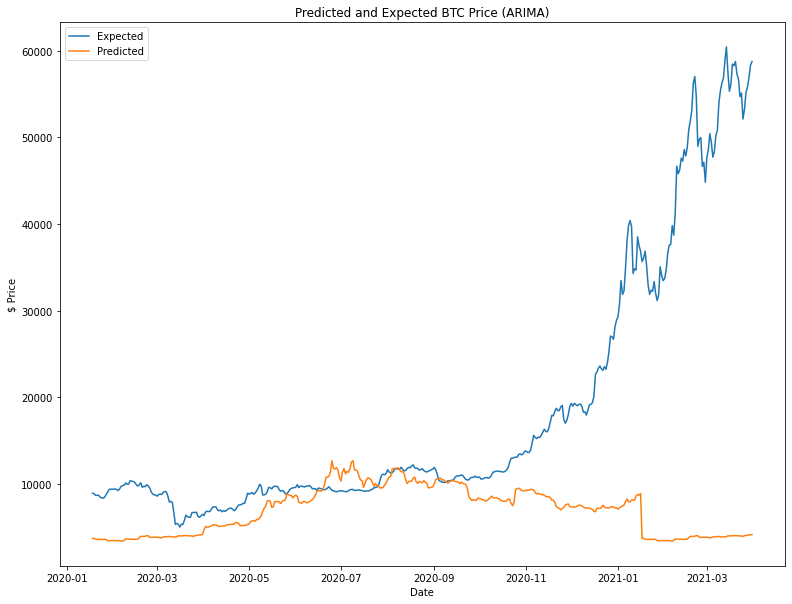

In [26]:
plt.figure(figsize=(13,10))
plt.plot(plotDates, test, label='Expected')
plt.plot(plotDates, predicted_results, label='Predicted')
plt.ylabel('$ Price')
plt.xlabel('Date')
plt.legend(loc='best')
plt.title('Predicted and Expected BTC Price (ARIMA)')
plt.show()

## **4. LSTM**
Long Short-Term Memory (LSTM) models are a type of recurrent neural network capable of learning sequences of observations. This makes them a deep learning network well suited for time series forecasting. However, usually a LTSM would struggle with a time series dataset as volatile and unpredictable as Bitcoin. After a grueling process of trying to apply my data, I finally trained the model. In my final fit I used 50 epochs and the “adam” optimizer. (This model is inspired by another user's kaggle notebook).

In [27]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Dropout,Flatten
from tensorflow.keras import Sequential
from statsmodels.graphics.tsaplots import plot_acf

In [28]:
price = df2.Weighted_Price
# As usual split data, 70, 30
X = price
size = int(len(X) * 0.7)
train_df, test_df = X[0:size], X[size:len(X)]
training_values = train_df.values
training_values = np.reshape(training_values, (len(training_values), 1))

# Scale the data using minMaxScaler
scaler = MinMaxScaler()
training_values = scaler.fit_transform(training_values)
# assign training values
x_train = training_values[0: len(training_values)-1]
y_train = training_values[1: len(training_values)]
x_train = np.reshape(x_train, (len(x_train), 1, 1))

In [29]:
# creates model
model = Sequential()
model.add(LSTM(10,input_shape = (None,1), activation="relu", return_sequences=True))
model.add(Dense(1))

In [30]:
model.compile(loss="mean_squared_error",optimizer="adam")

In [31]:
# fit the model to the training data
model.fit(x_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
32/32 [==============================] - 1s 2ms/step - loss: 0.1433
Epoch 2/50
32/32 [==============================] - 0s 2ms/step - loss: 0.1155
Epoch 3/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0914
Epoch 4/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0789
Epoch 5/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0598
Epoch 6/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0506
Epoch 7/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0408
Epoch 8/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0349
Epoch 9/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0287
Epoch 10/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0241
Epoch 11/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0238
Epoch 12/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0211
Epoch 13/50
32/32 [==============================

In [32]:
# assign test and predicted values + reshaping + converting back from scaler
test_values = test_df.values
test_values = np.reshape(test_values, (len(test_values), 1))
test_values = scaler.transform(test_values)
test_values = np.reshape(test_values, (len(test_values), 1, 1))
predicted_price = model.predict(test_values)
predicted_price = np.reshape(predicted_price, (len(predicted_price), 1))
predicted_price = scaler.inverse_transform(predicted_price)

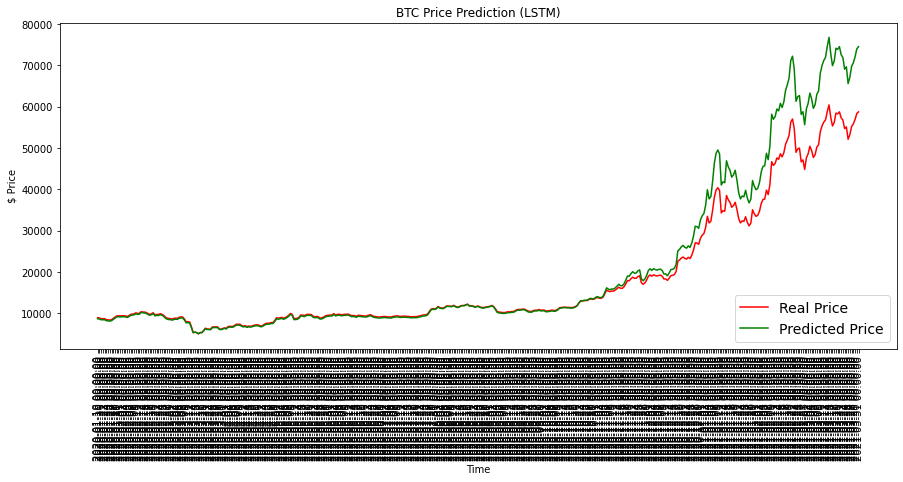

In [33]:
# plotting the results
plt.figure(figsize=(15, 6))
ax = plt.gca()  
plt.plot(test_df.values, color = 'red', label = 'Real Price')
plt.plot(predicted_price, color = 'green', label = 'Predicted Price')
plt.title('BTC Price Prediction (LSTM)')
test_df = test_df.reset_index()
x= test_df.index
labels = test_df['Timestamp']
plt.xticks(x, labels, rotation = 'vertical')
plt.xlabel('Time')
plt.ylabel('$ Price')
plt.legend(loc=4, prop={'size': 14})
plt.show()

In [34]:
rmse = np.sqrt(mean_squared_error(test_df.Weighted_Price.values, predicted_price))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 5200.278


## **6. Conclusion**
The final results of the experiment are plotted below. The Long Short-Term Memory model proves to be the most effective when handling volatile and hard-to-predict data like Bitcoin prices. This Bitcoin dataset consisted of extremely volatile and abnormal time series data. Therefore, I was unsurprised to find that the models had a difficult time predicting the most recent 439 days of prices. In addition, I acknowledge that I could’ve picked better and more informed parameters for some of these models and libraries in order to make the results more fair. However, I think the LSTM model’s low RMSE proves how powerful neural networks can be in Machine Learning. I’d love to explore RNN’s in financial time series data more in the future!


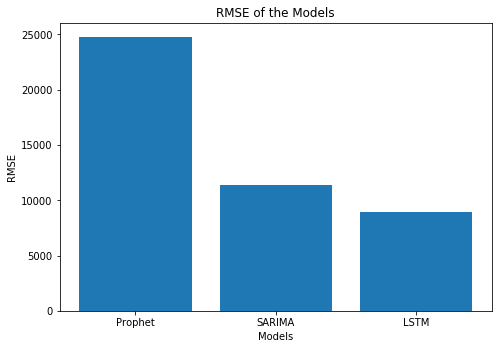

In [24]:
# Final graph for the RMSE's of each model
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
modelz = ['Prophet', 'SARIMA', 'LSTM']
nums = [24810,11371,8950]
ax.bar(modelz,nums)
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('RMSE of the Models')
plt.show()
plt.show()

Thank you so much for reading! Let me know your thoughts and comments on the notebook!